<div style="text-align: left">
[<img src="img/logoUPSayPlusCDS_990.png" width="800px">](http://www.datascience-paris-saclay.fr)
</div>

# [RAMP](https://www.ramp.studio/problems/mars_craters) on Mars craters detection

_Alexandre Boucaud (CDS), Joris van den Bossche (CDS), Balazs Kegl (CDS), Frédéric Schmidt (GEOPS), Anthony Lagain (GEOPS)_

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction

Impact craters in planetary science are used to date planetary surfaces, to characterize surface processes and to study the upper crust of terrestrial bodies in our Solar System (Melosh, 1989). Thanks to the Martian crater morphology, a wide amount of information could be deduced on the geological history of Mars, as for example the evolution of the surface erosion rate, the presence of liquid water in the past, the volcanic episodes or the volatiles layer in the subsurface (Carr & Head, 2010). These studies are widely facilitated by the availability of reference crater databases. 

Surveying impact craters is therefore an important task which traditionally has been achieved by means of visual inspection of images. The enormous number of craters smaller than one kilometer in diameter, present on high resolution images, makes visual counting of such craters impractical. In order to overcome this problem, several algorithms have been developed to automatically detect impact structures on planetary images (Bandeira et al., 2007 ; Martins et al., 2009). Nevertheless, these method allow to detect only 70-80 % of craters (Urbach & Stepinski, 2009).

### The prediction task

This challenge proposes to design the best algorithm to detect crater position and size starting from the most complete Martian crater database containing 384 584 verified impact structures larger than one kilometer of diameter (Lagain et al. 2017). We propose to give to the users a subset of this large dataset in order to test and calibrate their algorithm. 

<img src="img/craters_sample.png" width="70%">
<div style="text-align: center">Example of THEMIS reprojected data</div>


We provide THEMIS nightime dataset (Christensen et al., 2003)
already projected to avoid distortion, sampled at various scales and positions in form 224x224 pixels images. Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide detection of more than 90% (crater center and diameter) with a minimum number of wrong detection.

### References

1. Bandeira, L.; Saraiva, J. & Pina, P., Impact Crater Recognition on Mars Based on a Probability Volume Created by Template Matching, IEEE Transactions on Geoscience and Remote Sensing, Institute of Electrical and Electronics Engineers (IEEE), 2007, 45, 4008-4015 

2. Carr, M. H. and Head, J. W. III. (2010) Geologic history of Mars. Earth and Planetary Science Letters, 294, 185-203.

3. Christensen, P. R.; Bandfield, J. L.; Bell, J. F.; Gorelick, N.; Hamilton, V. E.; Ivanov, A.; Jakosky, B. M.; Kieffer, H. H.; Lane, M. D.; Malin, M. C.; McConnochie, T.; McEwen, A. S.; McSween, H. Y.; Mehall, G. L.; Moersch, J. E.; Nealson, K. H.; Rice, J. W.; Richardson, M. I.; Ruff, S. W.; Smith, M. D.; Titus, T. N. & Wyatt, M. B., Morphology and Composition of the Surface of Mars: Mars Odyssey THEMIS Results, Science, 2003, 300, 2056-2061 

4. Lagain, A., Marmo, C., Delaa, O., Bouley, S., Baratoux, D., Costard, F. et al. (2017) Martian crater database: 1. Reviewing and adapting to surface ages measurement. Submission to the Journal of Geophysical Research planned to November 2017.

5. Martins, R.; Pina, P.; Marques, J.S & Silveira, M., Crater Detection by a Boosting Approach, IEEE Geoscience and Remote Sensing Letters, Institute of Electrical and Electronics Engineers (IEEE), 2009, 6, 127-131

6. Melosh, H. J. (1989) Impact cratering: a geologic process. Oxford University Press.

7. Urbach, E. and Stepinski, T. (2009) Automatic detection of sub-km craters in high resolution planetary images. Planetary and Space Science, 57, 880-887.

## Preprocessing

### From raw data to local quadrangles

The full THEMIS map of Mars has been saved in a cylindrical projection.    Raw visualization of the full map is thus quite difficult.

<img src="img/full_image.png" width="80%">
<div style="text-align: center">Raw THEMIS data</div>

In order to correct for the distortions and recover the circularity of the craters, the map has to be reprojected locally. For that, we use a partitions known as _quadrangles_. 140 quadrangles are used to cover the whole Mars surface and we have used only a few of them for this exercice.

<img src="img/quadrangles.png" width="95%">
<div style="text-align: center">Quadrangle division in the raw THEMIS projection</div>

We use the boundaries of the quadrangle to extract the relevant pixels from the raw THEMIS map (above). Here we choose the quadrangle #77, close to the equator, and thus only slightly distorted.

<img src="img/quad_77_original_small.png" width="80%">
<div style="text-align: center">Quadrangle 77</div>

Then we reproject the pixel to the local stereographic projection in order to correct for the distortions. The result can be seen below.

<img src="img/quad_77_localstereo_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected</div>

For illustration, we use the crater database to project the labelled craters per category on the reprojected map.

<img src="img/quad_77_local_craters_small.png" width="80%">
<div style="text-align: center">Quadrangle 77 reprojected with labelled craters</div>

### From quadrangles to input data

After selecting a common **shape for the input** of image processing models **224x224**, we start from the reprojected quadrangles and decide to create the patches from a tiling with overlap to cover the craters falling on the edges. The tiling is also performed on downsampled versions of the quadrangles, until all craters can be detected for all sizes of craters present.
With the current set up, the **craters** contained in every image **have radii** that span the range **of 5 to 28 pixels**.

With no further do, let's have a look at the data..

### The input data

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~800Mb of images.

In [ ]:
# !python download_data.py

#### Load the data

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import rampwf as rw

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
%matplotlib inline

In [2]:
X_train = np.load('data/data_train.npy', mmap_mode='r')

print("The train data is made of {} images of {}x{} pixels".format(*X_train.shape))

n_img = len(X_train)

The train data is made of 10000 images of 224x224 pixels


Here we display 3 randomly select images, you can play around with the values.

In [3]:
idx_list = [30, 3470, 9030]

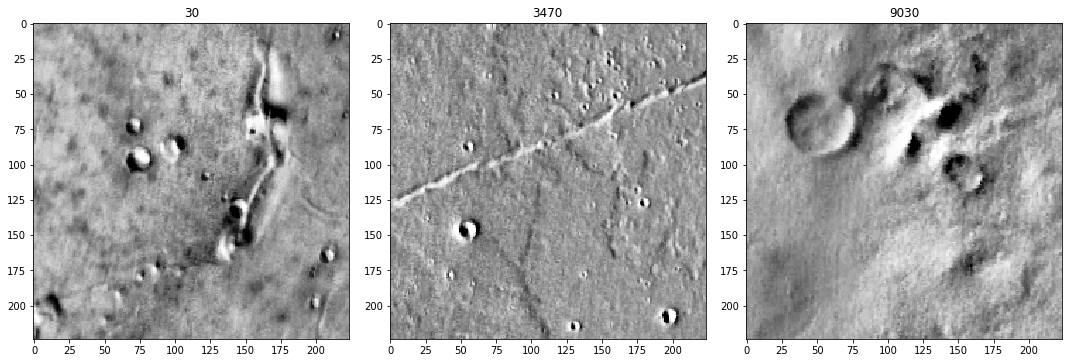

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

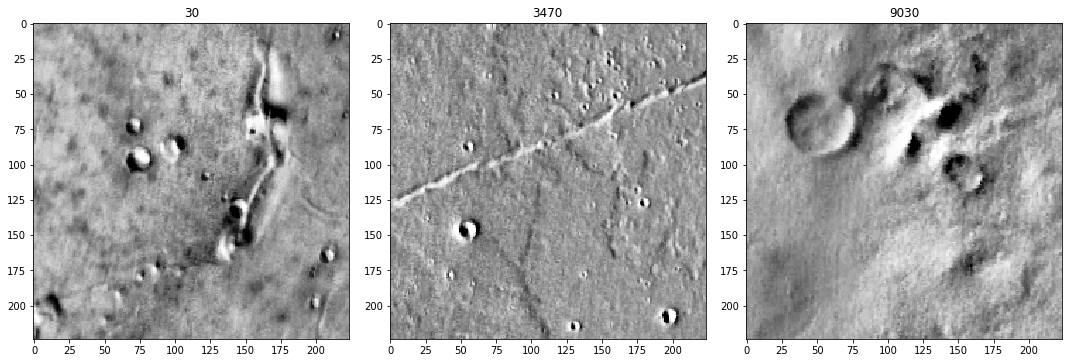

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, idx in enumerate(idx_list):
    axes[i].imshow(X_train[idx], cmap='Greys_r')
    axes[i].set_title('%d' % idx)
fig.tight_layout()

Most images have some craters but the labeled craters are only the one whose diameter is superior to 10 pixels.

In [6]:
y_train = pd.read_csv('data/labels_train.csv')

In [7]:
y_train.head()

,i,row_p,col_p,radius_p
0,0,57.0,175.0,6.70
1,1,57.0,7.0,6.70
2,4,37.0,70.0,5.25
3,4,121.0,66.0,8.35
4,7,145.0,71.0,6.70


The labels consist of a `pandas.DataFrame` containing the list of craters. For each craters, the columns are
- `id`: index of the image it belongs to
- `row_p`, `col_p` : pixel position
- `radius_p` : pixel radius

Let's visualize some.

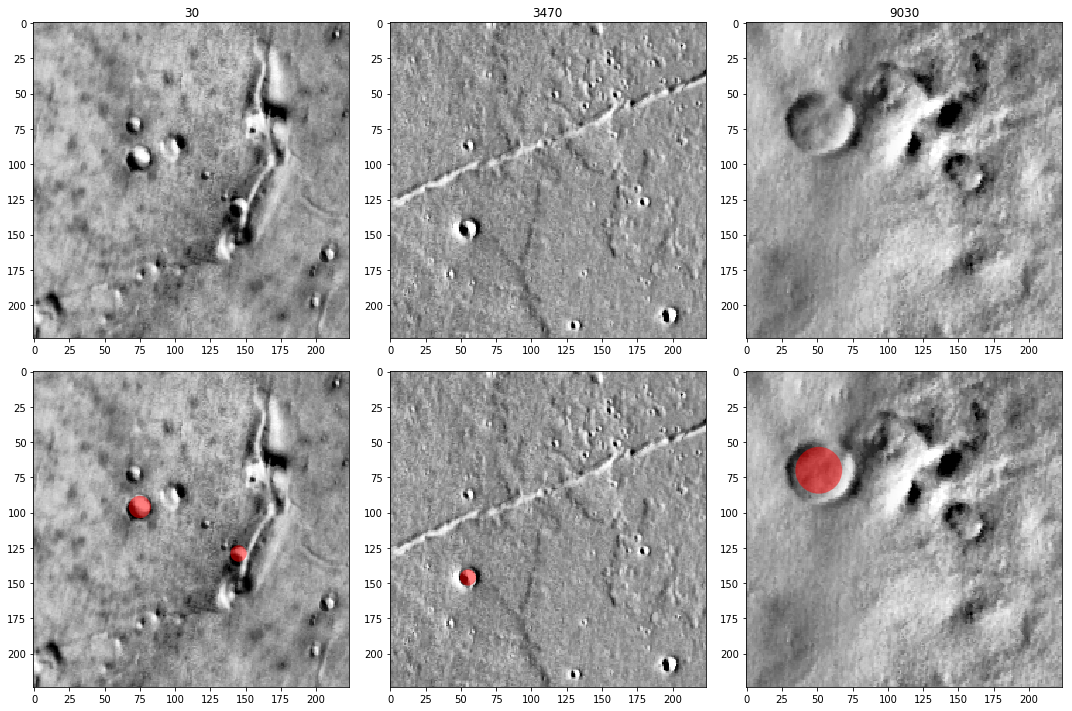

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_list):
    img = X_train[idx]
    lab = y_train[y_train['i'] == idx][['row_p', 'col_p', 'radius_p']].values
    # First row images only
    axes[0, i].imshow(img, cmap='Greys_r')
    axes[0, i].set_title('%d' % idx)
    # Second row, labels overlaid on the image
    axes[1, i].imshow(img, cmap='Greys_r')
    if lab.size != 0:
        for y, x, radius in lab:
            crater = Circle((x, y), radius, color='r', ec=None, alpha=0.5)
            axes[1, i].add_patch(crater)
fig.tight_layout()

### Labels distribution

#### Individual craters

In [19]:
print("There are {} labeled craters in the training set".format(y_train.size))

There are 32288 labeled craters in the training set


#### Lots of "empty" images

In [70]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters for only {:.1%} of the images".format(n_img_withcraters / n_img))

There are labeled craters for only 53.5% of the images


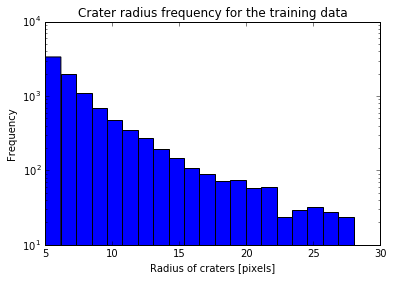

In [76]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

## Workflow

<img src="img/workflow.svg" width="100%">

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the function `image_preprocessor`, which will be used to transform the images. 
* a class `BatchClassifier` that will handle the training and prediction using sample generators.

### Image preprocessor

MNIST contains well-centered and aligned images so we do nothing in the image preprocessor.

In [70]:
%%file submissions/starting_kit/image_preprocessor.py
def transform(x):
    return x



Overwriting submissions/starting_kit/image_preprocessor.py


# The batch classifier

Your convnet models will be implemented in the `batch_classifier.py` workflow element. The model is usually implemented in a separate build_model function which is called from init. It does not do any computation, just building the network architecture. Your main task is to find the right architecture for this data set. Every parameter is "free": the size of the input layer (which should match the preprocessing you do in `image_preprocessing.transform`), the number and composition of the convolutional blocks, the size and number of filters in each layer, the number and size of the fully connected layers, the regularization that you apply (usually only on the fully connected layers), and the optimizer. In addition, in the fit function you shold decide the size of the minibatches and the number of epochs. 

The starting kit is using [keras](https://keras.io). MNIST could be loaded into memory at once, but in general, image data sets are too big for this, so instead of a set of images, your `batch_classifier.fit` function will receive a <i>generator</i>. The type of this generator is `BatchGeneratorBuilder` that you can find in [`rampwf.workflows.image_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/image_classifier.py). You will interact with it by calling its `get_train_valid_generators` function. This function will still not return data, since typically you would call the `fit` function of a keras neural net with it, which would again result in filling the memory too fast. Instead, it returns two other generators that you will pass to the `fit_generator` function of a keras model. Why two? The first generator will generate _training_ images for keras, and the second generator generates _validation_ images, which you can use to monitor the learning curves when developing the model. Normally you will not need validation samples in your submission (only when you develop your models outside of the RAMP server) unless you implement automatic early stopping based on validation accuracy.

The `BatchGeneratorBuilder.get_train_valid_generators` function expects two parameters:
* `valid_ratio`: the ratio of the minibatch that should be used for validation, typically 0.1, and
* `batch_size`: the number of images keras' `fit_generator` will get for every minibatch.
The batch size is an important hyperparameter. Statistically, a larger batch size means more precise gradient estimates but computationally slower steps. More importantly, you will have to carefully set the batch size for staying within the memory, depending on the input image size, your network architecture, and your backend. In the starting kit we use 32 images per minibatch. 

In [72]:
%%file submissions/starting_kit/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from rampwf.workflows.image_classifier import get_nb_minibatches


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 32
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            # Total number of steps (batches of samples) to yield from
            # generator before declaring one epoch finished and starting the
            # next epoch. It should typically be equal to the number of unique
            # samples of your dataset divided by the batch size.
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=1,
            # In parallel to training, a CPU process loads and preprocesses
            # data from disk and put it into a queue in the form of
            # mini-batches of size `batch_size`.`max_queue_size` controls the
            # maximum size of that queue. The size of the queue should be big
            # enough so that the training process (GPU) never
            # waits for data (the queue should be never be empty).
            # The CPU process loads chunks of 1024 images each time, and
            # 1024/batch_size mini-batches from that chunk are put into the
            # queue. Assuming training the model on those 1024/batch_size
            # mini-batches is slower than loading a single chunk of 1024
            # images, a good lower bound for `max_queue_size` would be
            # (1024/batch_size). if `batch_size` is 16, you can put
            # `max_queue_size` to 64.
            max_queue_size=64,
            # WARNING : It is obligatory to set `workers` to 1.
            # This in principle controls the number of workers used
            # by keras to load mini-batches from disk to memory in parallel
            # to GPU training. But I don't like the way it works and their
            # code is not very commented/used, so I dont trust it that much
            # (we might have surprises).
            # The way it works in keras is by launching in parallel `workers`
            # threads or processes which will all use a copy of the generator
            # passed to `fit_generator`. So if nothing is done and `workers`
            # is set to some number > 1, the neural net will be trained with
            # repetitions of the same data, because the workers are independent
            # and they got through the same generator.
            # Hence it is necessary to introduce a shared lock between the the
            # processes so that they load different data, this can become a bit
            # complicated, so I choose to rather load exactly one chunk at a
            # time using 1 worker (so `workers` have to be equal to 1), but
            # do this single chunk loading in parallel with joblib.
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        inp = Input((1, 28, 28))
        x = Flatten(name='flatten')(inp)
        x = Dense(100, activation='relu', name='fc1')(x)
        out = Dense(10, activation='softmax', name='predictions')(x)
        model = Model(inp, out)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=SGD(lr=1e-4),
            metrics=['accuracy'])
        return model



Overwriting submissions/starting_kit/batch_classifier.py


## Scoring

`y_true` and `y_pred` can have variable length

- What is a detection ?
- What is the distance between two lists of predictions ?
- How do we rank the various models ?


#### Intersetion over Union : IoU

Distance in (x, y, r) space computed using IoU (adapted for circles in this problem)

<img src="img/iou_formula.png" width="30%">
<img src="img/iou_examples.png" width="70%">

Detection can start at `IoU > 0` but traditionally an object is detected if **`IoU > 0.5`**.

#### Confidence level

Each prediction should be associated with a confidence, so that they can be ranked. The confidence value should be the first one that appears, before `x, y, radius`.

#### Matching

The Hungarian method [`O(N log(N))`] is used to compute the best match between the true and predicted list.

### Metric #1 Average Precision

- **precision**: fraction of correct predictions
- **recall**: fraction of true objects that are predicted

Precision and recall are computed as a function of the confidence value threshold to produce the mean Average Precision (mAP) curve.

<img src="img/precision-recall-curve.png" width="70%">


### Metric #2 OSPA

[OSPA](http://www.dominic.schuhmacher.name/papers/ospa.pdf) is a miss-distance between the best match of two lists of objects with various size. It penalizes the both the distance between the best match entries and the size difference, referred to as _cardinality_.

The distance used here is the IoU for circles.

<img src="img/ospa_figure2.png" width="80%">
<div style="text-align: center">Various examples of sets of entries and their corresponding OSPA value.</div>

### Metric #3 SCP

_Superposed Cylinders and Prisms_ is a new score based on the projection of true and predicted craters on a rasterized image (mask).

We construct the mask by projecting circles: true craters as positive and predicted ones as negative.

<img src="img/det_mask.png" width="65%">

The craters are **inverse weighted** by their area so the sum over a given crater is normalized to unity.

The **score** is obtained as the sum of the absolute value of the mask.

## Some attention points when building the model

<div class="alert alert-danger">

 <ul>
  <li>In the ground truth labels, **only craters are present with a radius of 5 to 28 pixels**. You should make sure your model also only predicts craters in this range, otherwise it will be penalized for finding (possibly existing) craters not present in the ground truth.</li>
  <li>All metrics, except for Average Precision, are calculated by selecting the set of predictions based on a **confidence threshold of 0.5**. So you should **rescale the returned value of the confidence** so that the best threshold for your model is rescaled to 0.5.</li>
</ul> 

</div>

## Deep net example

In [8]:
!pip install git+https://github.com/paris-saclay-cds/ssd_keras.git

  Cloning https://github.com/paris-saclay-cds/ssd_keras.git to /storage/workspace/tmp/pip-lrc6djl9-build
  Running setup.py install for ssd-keras ... done


In [1]:
import problem

In [9]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_train_data()

In [3]:
y_train

array([[(57.0, 175.0, 6.7000000000000002)],
       [(57.0, 7.0, 6.7000000000000002)], [], ...,
       [(21.0, 125.0, 5.8499999999999996)],
       [(37.0, 90.0, 5.7999999999999998)], []], dtype=object)

In [4]:
len(y_train)

10000

In [5]:
y_train[4]

[(37.0, 70.0, 5.25), (121.0, 66.0, 8.3499999999999996)]

In [6]:
import sys
sys.path.append('./submissions/keras_ssd7/')

In [10]:
from object_detector import ObjectDetector

In [11]:
model = ObjectDetector()

In [12]:
model.fit(X_train, y_train)

In [13]:
y_pred = model.predict(X_test[:100])

In [15]:
import rampwf

In [29]:
from rampwf.score_types.detection import AverageDetectionPrecision, DetectionPrecision, DetectionRecall, SCP

In [31]:
average_precision = AverageDetectionPrecision()
precision = DetectionPrecision()
recall = DetectionRecall()
scp = SCP(shape=(224, 224), minipatch=[56, 168, 56, 168])

In [19]:
average_precision(y_test[:100], y_pred)

/home/parietal/jvandenb/ramp-workflow/rampwf/score_types/detection.py:449: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all


0.54312853515789206

In [24]:
precision(y_test[:100], y_pred)

0.9375

In [26]:
recall(y_test[:100], y_pred)

0.58750000000000002

In [27]:
precision(y_test[:100], y_pred, conf_threshold=0.3)

0.45192307692307693

In [28]:
recall(y_test[:100], y_pred, 0.2)

0.88749999999999996

In [33]:
import numpy as np

In [43]:
ps = []
rs = []
scps = []

for conf_threshold in np.linspace(0, 0.6, 50):
    ps.append(precision(y_test[:100], y_pred, conf_threshold=conf_threshold))
    rs.append(recall(y_test[:100], y_pred, conf_threshold=conf_threshold))
    scps.append(scp(y_test[:100], y_pred, conf_threshold=conf_threshold))
    
ps = np.array(ps)
rs = np.array(rs)

In [36]:
ap = average_precision(y_test[:100], y_pred)

/home/parietal/jvandenb/ramp-workflow/rampwf/score_types/detection.py:449: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all


In [37]:
import matplotlib.pyplot as plt

In [39]:
%matplotlib inline

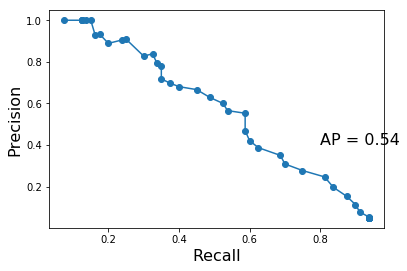

In [40]:
fig, ax = plt.subplots()
ax.plot(rs, ps, 'o-')
ax.set_xlabel('Recall', fontsize=16)
ax.set_ylabel('Precision', fontsize=16)
ax.set(xlim=()
ax.text(0.8, 0.4, 'AP = {:.2f}'.format(ap), fontsize=16)

In [41]:
conf_thresholds = np.linspace(0, 0.6, 50)

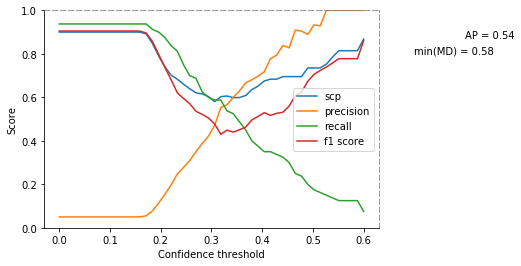

In [44]:
fig, ax = plt.subplots()
ax.plot(conf_thresholds, scps, label='scp')
ax.plot(conf_thresholds, ps, 'C1', label='precision')
ax.plot(conf_thresholds, rs, 'C2', label='recall')
ax.plot(conf_thresholds, 1 - (2*(ps * rs) / (ps + rs)) , 'C3', label='f1 score')

ax.legend(loc=7)

ax.set_xlabel("Confidence threshold")
ax.set_ylabel("Score")

ax.set_ylim(0, 1)

#ax.axhline(1, linestyle='--', color='grey')
#ax.axvline(conf_thresholds[17], color='grey', linestyle='--')
ax.spines['top'].set(linestyle='--', color='grey')
ax.spines['right'].set(linestyle='--', color='grey')
    
ax.text(0.8, 0.87, 'AP = {:.2f}'.format(ap))
ax.text(0.7, 0.80, 'min(MD) = {:.2f}'.format(np.min(scps)))

In [ ]:
rampwf.score_types.detection.precision_recall_curve()

In [ ]:
rampwf.score_types.detection.precision_recall_curve()

## Local testing/exploration

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

Check list

- Install the `ramp-workflow` locally

In [ ]:
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow@mars_craters

- Make sure that the python files `image_preprocessor.py` and `batch_classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data)
- If you haven't yet, downlad the images by executing 
  ```
  python download_data.py
  ```

Finally, make sure the local processing goes through by running the
```
ramp_test_submission
```

In [73]:
!ramp_test_submission

Testing MNIST classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
Using TensorFlow backend.
Epoch 1/1
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The 

If you get to see the train and test scores, and no errors, then you can submit your model to the ramp.studio.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [MNIST](http://www.ramp.studio/events/MNIST) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/MNIST/sandbox) and copy-paste (or upload) [`image_preprocessor.py`](/edit/submissions/starting_kit/image_preprocessor.py) and [`batch_classifier.py`](/edit/submissions/starting_kit/batch_classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/MNIST/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/MNIST/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/MNIST/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train acc = 0.55 ± 0.0
train nll = 14.53 ± 0.0
valid acc = 0.55 ± 0.0
valid nll = 14.65 ± 0.0
test acc = 0.55 ± 0.0
test nll = 14.6 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/MNIST/leaderboard)) is balanced accuracy aka macro-averaged recall, so the line that is relevant in the output of `ramp_test_submission` is `valid acc = 0.55 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=Mars crater notebook).